In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
data = np.genfromtxt("test.txt", dtype=None,names = ['time','t_errUp', 't_errdwn', 'Flux', 'Fluxup','Flux_dwn'],usecols=(0,1,2,3,4,5),unpack=True)

data=np.array(data)

t_050315 = data[0,:]
t_050315_up = data[1,:]
t_050315_down = data[2,:]
Flux_050315 = data[3,:]
Flux_050315_up = data[4,:]
Flux_050315_down = data[5,:]

In [3]:
#def linear_fit(x,m,c):
 #  return  c*x**(-m)
   

In [3]:
#def linear_fit(x,m,c):
 #   return  c*x**(-m)
    
def bkn_pow(xvals,breaks,alphas):
    try:
        if len(breaks) != len(alphas) - 1:
            raise ValueError("Dimensional mismatch. There should be one more alpha than there are breaks.")
    except TypeError:
        raise TypeError("Breaks and alphas should be array-like.")
    if any(breaks < np.min(xvals)) or any(breaks > np.max(xvals)):
        raise ValueError("One or more break points fall outside given x bounds.")
    
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    #alpha = pd.cut(pd.Series(xvals),breakpoints,labels=alphas,include_lowest=True).to_numpy()

    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals) # add this piece to the output
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) # scale the beginning of each piece to the end of the last so it is continuous
    
    return(np.array([y for ychunk in all_y for y in ychunk])) # return flattened list

def bkn_pow_smooth(x, A, x_b, a_1, a_2, delta=1):
    a_1 *= -1
    a_2 *= -1
    return A*(x/x_b)**(-a_1) * (0.5*(1+(x/x_b)**(1/delta)))**((a_1-a_2)*delta)

In [7]:
xbounds = (-1,7) # log of x bounds
#num_points = 200
x = t_050315
#breaks = [0.8e2,0.5e3,3e2]
breaks = [0.8e2,0.5e3]
#alphas = [+0.1,+3,-2.5, -1]
alphas = [+0.1,+3,-2.5]
y = bkn_pow(x,breaks,alphas)

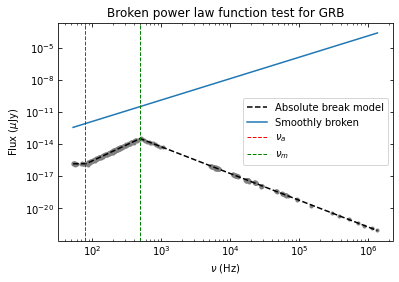

In [8]:
noisy = y * np.random.normal(1,0.1,len(y)) # add Gaussian noise to the data
labels = iter([r'$\nu_a$',r'$\nu_m$',r'$\nu_c$'])
colors = iter('rgb')

plt.loglog(x,noisy/1e16,marker='.',linestyle="",color='grey')
plt.loglog(x,y/1e16,'k--',label="Absolute break model")
plt.loglog(x,bkn_pow_smooth(x,2.2e4,4e10,2,-1,delta=1.1),label="Smoothly broken")

for br in breaks:
    plt.axvline(br,linestyle="--",lw=1,color=next(colors),label=next(labels))

plt.legend()
plt.gca().tick_params(axis='both',which='both',direction='in',top=True,right=True)
plt.xlabel(r"$\nu$ (Hz)")
plt.ylabel(r"Flux ($\mu$Jy)")
plt.title("Broken power law function test for GRB")
plt.show()

In [4]:
params, covariance = curve_fit(f = linear_fit, xdata = t_050315, ydata = Flux_050315)

print('Slope (m) is ', params[0])
print('Intercept (c) is ', params[1])
print(covariance)

Slope (m) is  0.71699757174732
Intercept (c) is  3.9361553015026294e-07
[[9.28409427e-03 1.75420892e-08]
 [1.75420892e-08 3.35971315e-14]]


In [5]:
standarddevparams2 = np.sqrt(np.diag(covariance))
residuals = Flux_050315 - linear_fit(t_050315,params[0],params[1])
squaresumofresiduals = np.sum(residuals**2)
squaresum = np.sum((Flux_050315-np.mean(Flux_050315))**2)
R2 = 1 - (squaresumofresiduals/squaresum)

print('The value of fitting parameters with their errors')
print('The slope (m) is ', params[0],'+-', standarddevparams2[0])
print('The intercept (c) is ', params[1],'+-', standarddevparams2[1])
print('The R^2 value is ', R2)

The value of fitting parameters with their errors
The slope (m) is  0.71699757174732 +- 0.09635400495011125
The intercept (c) is  3.9361553015026294e-07 +- 1.8329520310197961e-07
The R^2 value is  0.2952313066059753


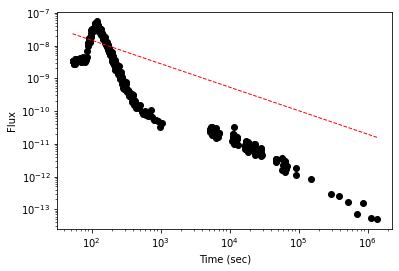

In [32]:
plt.scatter(t_050315,Flux_050315, c='black')
plt.xlabel('Time (sec)')
plt.ylabel('Flux')
#plt.ylim(0.9e2,1e-10)
#plt.xlim(0.7e2,3e3)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.plot(t_050315, linear_fit(t_050315,params[0],params[1]),c='red',ls='--',lw=1)
plt.savefig('break_test_fit.png')
plt.show();

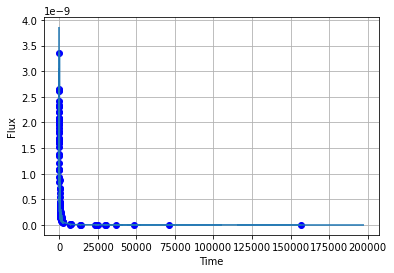

In [7]:
plt.plot(t_050315, Flux_050315, 'bo')
plt.errorbar(t_050315, Flux_050315, xerr=t_050315_up,  yerr=Flux_050315_up)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid()
plt.savefig('121128A_err.png')
#plt.savefig('GRB180720C.pdf')
plt.show()